### I. Import Various Libraries, Read in data and Remove Data Errors

In [359]:
import talib
import zipline
import time
import pandas as pd
from datetime import datetime,timedelta
import statsmodels.api as sm
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.ticker as ticker
from matplotlib.finance import candlestick2_ohlc
import plotly.plotly as py
from sklearn import linear_model,svm,ensemble,cross_validation,grid_search,metrics,kernel_ridge
from plotly.tools import FigureFactory as FF

%matplotlib inline

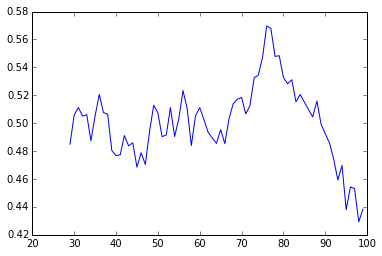

In [4]:
#test talib
close = np.random.random(100)
output = talib.SMA(close)
plt.plot(output)

In [5]:
df=pd.read_csv('/home/nightrose/Documents/Github/try/xyz/data.1_min.csv',header=None,names=('time','price'))
df.head()

,time,price
0,1990-01-08 15:32:00,411.25
1,1990-01-08 15:33:00,411.25
2,1990-01-08 15:34:00,411.75
3,1990-01-08 15:35:00,411.50
4,1990-01-08 15:36:00,411.50


In [6]:
df.time=[datetime.strptime(x,'%Y-%m-%d %H:%M:%S') for x in df.time]

In [7]:
type(df.time[0])

pandas.tslib.Timestamp

In [8]:
df=df.set_index('time')

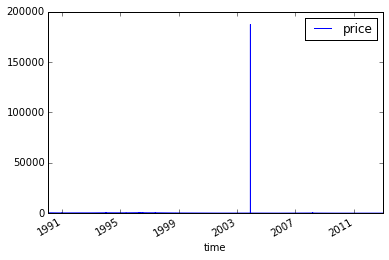

In [9]:
#plotting it along time line, found an outlier
df.plot()

In [10]:
#replace the price point with price in the previous minute. 
temp=df[df['price']>5000].index
df.loc[temp,'price']=df.loc[temp+timedelta(minutes=1),'price']

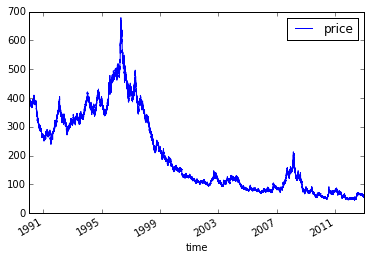

In [11]:
#check to see whether outliers are all removed
df.plot()

In [12]:
#check for duplications
df.index.is_unique

True

In [360]:
#create daily data and reserve open, high, low, close.
df_daily=df.resample('B',how='ohlc')
df_daily.head(10)
df_daily.dropna(how='any',axis=0,inplace=True)
df_daily.columns=df_daily.columns.droplevel(0)

In [363]:
df_daily.to_csv('/home/nightrose/Documents/Github/try/xyz/data.daily.csv', sep='\t')

In [111]:
o=df_daily['open']
c=df_daily['close']
h=df_daily['high']
l=df_daily['low']
a=range(len(df_daily.index))
new=[]
for i in a:
    if i%365==0:
      new.append(i)  
x=df_daily.index

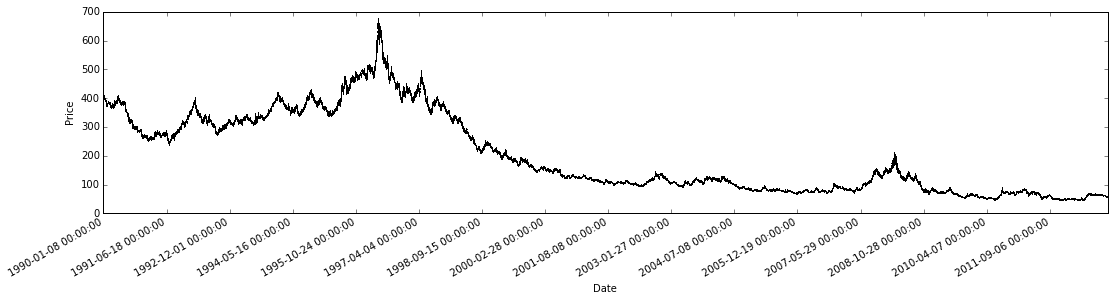

In [112]:
fig = plt.figure(figsize=(18,4))
ax1 = plt.subplot(1,1,1)
plt.ylabel('Price')
plt.xlabel('Date')
plt.xticks(new,x[new], rotation=45)
candlestick2_ohlc(ax1,o,h,l,c,width=1,colorup='k',colordown='r')
ax1.autoscale_view()
fig.autofmt_xdate()

In [199]:
#create log returns data on close price
df_daily['log_returns_close']= np.log(df_daily['close']) - np.log(df_daily['close'].shift(1))
#df_daily['log_returns_open']= np.log(df_daily['price']['open']) - np.log(df_daily['price']['open'].shift(1))
#df_daily['log_returns_high']= np.log(df_daily['price']['high']) - np.log(df_daily['price']['high'].shift(1))
#df_daily['log_returns_low']= np.log(df_daily['price']['low']) - np.log(df_daily['price']['low'].shift(1))

In [200]:
df_daily.drop(df_daily.head(1).index,inplace=True)

In [201]:
df_daily.head(10)

,open,high,low,close,log_returns_close
time,,,,,
1990-01-09,408.25,408.50,406.25,406.75,-0.007958
1990-01-10,406.00,406.25,403.25,405.50,-0.003078
1990-01-11,406.75,407.00,403.25,404.50,-0.002469
1990-01-12,406.75,406.75,400.75,402.00,-0.006200
1990-01-15,401.25,401.50,397.75,399.00,-0.007491
1990-01-16,399.50,401.00,397.75,398.00,-0.002509
1990-01-17,397.50,401.00,397.50,401.00,0.007509
1990-01-18,402.00,402.00,396.25,397.50,-0.008766
1990-01-19,397.00,397.00,392.00,392.00,-0.013933


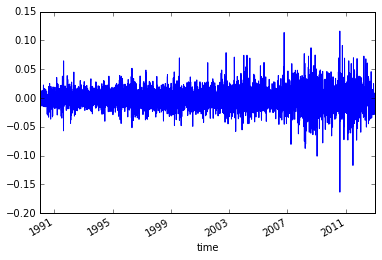

In [20]:
df_daily['log_returns_close'].plot()

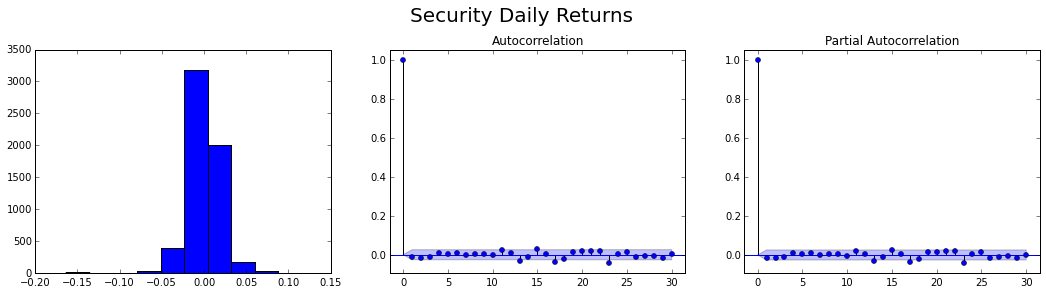

In [21]:
fig=plt.figure(figsize=(18,4))
fig.suptitle('Security Daily Returns',y=1.05,fontsize=20)
ax1 = fig.add_subplot(131)
ax1=plt.hist(df_daily['log_returns_close'])
ax2=fig.add_subplot(132)
ax2=sm.graphics.tsa.plot_acf(df_daily['log_returns_close'],lags=30,ax=ax2)
ax3=fig.add_subplot(133)
ax3=sm.graphics.tsa.plot_pacf(df_daily['log_returns_close'],lags=30,ax=ax3)


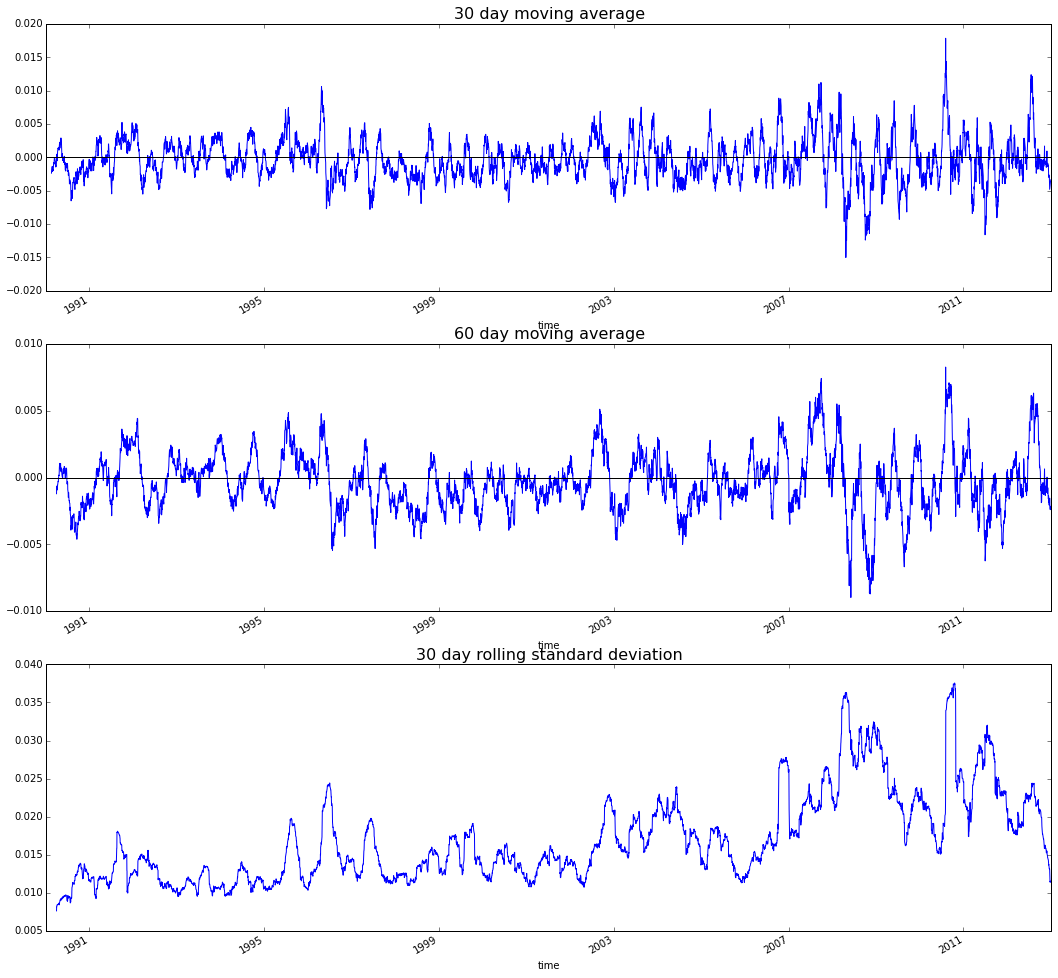

In [22]:
fig=plt.figure(figsize=(18,18))
ax1=fig.add_subplot(311)
ax1.set_title('30 day moving average',fontsize=16)
ax1=pd.rolling_mean(df_daily['log_returns_close'],30).plot()
ax1=plt.axhline(y=0,color='black')

ax2=fig.add_subplot(312)
ax2.set_title('60 day moving average',fontsize=16)
ax2=pd.rolling_mean(df_daily['log_returns_close'],60).plot()
ax2=plt.axhline(y=0,color='black')

ax3=fig.add_subplot(313)
ax3.set_title('30 day rolling standard deviation',fontsize=16)
ax3=pd.rolling_std(df_daily['log_returns_close'],60).plot()

It seems that the volativity increased over time and that should be incorporated into the model building. 

In [23]:
#look at within day price variations
df.tail()

,price
time,
2012-12-31 19:55:00,56.943190
2012-12-31 19:56:00,56.869951
2012-12-31 19:57:00,56.833332
2012-12-31 19:58:00,56.815022
2012-12-31 19:59:00,57.053048


check the last several days minute by minute patterns

## II. Explore minute by minute returns

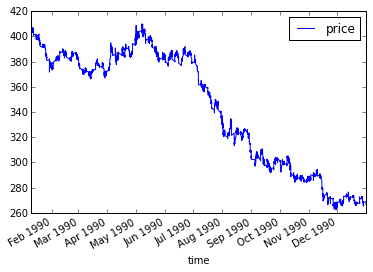

In [24]:
#because there are too much data, I only take a subset for exploration
start = '01/10/1990'
end = '12/31/1990'
df_last=df[start:end]
df_last.plot()

/home/nightrose/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nightrose/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:490: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nightrose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

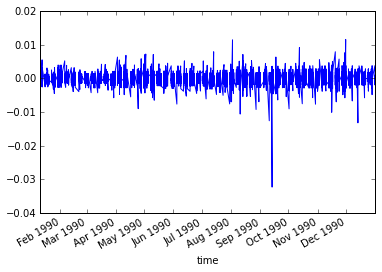

In [25]:
df_last.loc[:,'log_returns_min']= np.log(df_last.loc[:,'price']) - np.log(df_last.loc[:,'price'].shift(1))
df_last.drop(df_last.head(1).index,inplace=True)
df_last['log_returns_min'].plot()

In [26]:
#df_last.ix['1990-01-10 19:00:00':'1990-01-11 16:00:00', 'log_returns_min']

In [27]:
df_last['log_returns_min'].describe()

count    30899.000000
mean        -0.000014
std          0.001030
min         -0.032319
25%         -0.000752
50%          0.000000
75%          0.000749
max          0.011606
Name: log_returns_min, dtype: float64

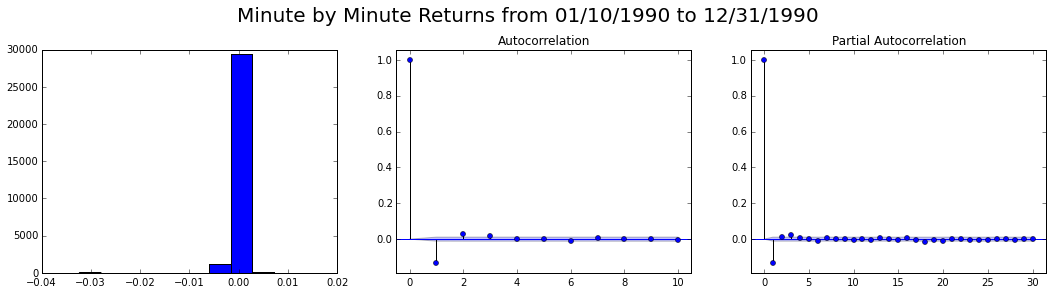

In [28]:
fig=plt.figure(figsize=(18,4))
fig.suptitle('Minute by Minute Returns from %s to %s'%(start,end),y=1.05,fontsize=20)
ax1 = fig.add_subplot(131)
ax1=plt.hist(df_last['log_returns_min'])
ax2=fig.add_subplot(132)
#ax2=sm.graphics.tsa.plot_acf(df_last['log_returns_min'],lags=30,ax=ax2)
ax2=sm.graphics.tsa.plot_acf(df_last['log_returns_min'],lags=10,ax=ax2)
ax3=fig.add_subplot(133)
ax3=sm.graphics.tsa.plot_pacf(df_last['log_returns_min'],lags=30,ax=ax3)

<Container object of 14 artists>

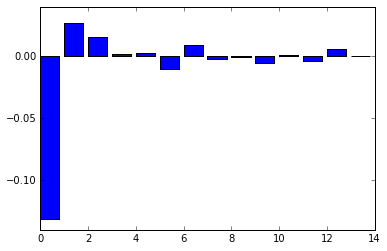

In [29]:
ACF0=sm.tsa.stattools.acf(df_last['log_returns_min'], nlags=14)
#ACF0.plot()
plt.bar(np.arange(14),ACF0[1:15])

From the analysis above, it seems that the minute by minute returns have mean reversion tendencies. However, some further analysis fail to find strong predictive power using this negative correlation. Thus I did not pursue this further, but turned to daily returns instead. 

## III. Return to daily data

** 3.1 First, create some technical indicators. **

In [290]:
df_daily.head()
#print(len(df_daily['close'].values))
#print(len(df_daily.index))

,open,high,low,close,log_returns_close,log_returns_close_1,lr_l1,lr_l2,lr_l3,lr_l4,lr_l5
time,,,,,,,,,,,
1990-01-09,408.25,408.50,406.25,406.75,-0.007958,-0.003078,NaN,NaN,NaN,NaN,NaN
1990-01-10,406.00,406.25,403.25,405.50,-0.003078,-0.002469,-0.007958,NaN,NaN,NaN,NaN
1990-01-11,406.75,407.00,403.25,404.50,-0.002469,-0.006200,-0.003078,-0.007958,NaN,NaN,NaN
1990-01-12,406.75,406.75,400.75,402.00,-0.006200,-0.007491,-0.002469,-0.003078,-0.007958,NaN,NaN
1990-01-15,401.25,401.50,397.75,399.00,-0.007491,-0.002509,-0.006200,-0.002469,-0.003078,-0.007958,NaN


In [289]:
df_daily['log_returns_close_1']=df_daily['log_returns_close'].shift(-1)
df_daily['lr_l1']=df_daily['log_returns_close'].shift(1)
df_daily['lr_l2']=df_daily['log_returns_close'].shift(2)
df_daily['lr_l3']=df_daily['log_returns_close'].shift(3)
df_daily['lr_l4']=df_daily['log_returns_close'].shift(4)
df_daily['lr_l5']=df_daily['log_returns_close'].shift(5)


In [291]:
start='01/01/2012'
end='12/31/2012'
from talib import MA_Type
close=df_daily[start:end]['close'].values
open0=df_daily[start:end]['open'].values
high=df_daily[start:end]['high'].values
low=df_daily[start:end]['low'].values
###Overlap Studies
#BBANDS - Bollinger Bands, with triple exponential moving average:
BBANDS_upper, BBANDS_middle, BBANDS_lower = talib.BBANDS(close, matype=0)
#DEMA - Double Exponential Moving Average
DEMA = talib.DEMA(close, timeperiod=20)
#EMA - Exponential Moving Average
EMA = talib.EMA(close, timeperiod=30)
#HT_TRENDLINE - Hilbert Transform - Instantaneous Trendline
HT_TRENDLINE = talib.HT_TRENDLINE(close)
#KAMA - Kaufman Adaptive Moving Average
KAMA = talib.KAMA(close, timeperiod=30)
df1 = pd.DataFrame({'BBANDS_upper': BBANDS_upper,'BBANDS_middle': BBANDS_middle,'BBANDS_lower': BBANDS_lower,
                    'DEMA ': DEMA },index=df_daily[start:end].index)

### Momentum Indicators
#ADX - Average Directional Movement Index
ADX= talib.ADX(high, low, close, timeperiod=14)
#APO - Absolute Price Oscillator
APO = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)#MA_Type.T3)
#Momentum
MOM = talib.MOM(close, timeperiod=10)
#Commodity Channel Index
CCI = talib.CCI(high, low, close, timeperiod=14)
df2 = pd.DataFrame({'ADX': ADX,'APO':APO,'MOM': MOM,'CCI': CCI },index=df_daily[start:end].index)

#NATR - Normalized Average True Range
NATR = talib.NATR(high, low, close, timeperiod=14)
#trange = talib.TRANGE(high, low, close)

#Pattern Recognition Functions
#Two Cows
CDL2CROWS = talib.CDL2CROWS(open0, high, low, close)
df3 = pd.DataFrame({'NATR': NATR,'CDL2CROWS':CDL2CROWS },index=df_daily[start:end].index)

###Cycle Indicator Functions
#HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
HT_DCPERIOD = talib.HT_DCPERIOD(close)
#HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
#HT_DCPHASE = talib.HT_DCPHASE(close)
#HT_PHASOR - Hilbert Transform - Phasor Components
HT_DCPHASE_inphase, HT_DCPHASE_quadrature = talib.HT_PHASOR(close)
#HT_SINE - Hilbert Transform - SineWave
#HT_SINE_sine, HT_SINE_leadsine = talib.HT_SINE(close)
#HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
HT_TRENDMODE = talib.HT_TRENDMODE(close)
#df4 = pd.DataFrame({'HT_DCPERIOD': HT_DCPERIOD ,'HT_DCPHASE':HT_DCPHASE,'HT_DCPHASE_inphase':HT_DCPHASE_inphase,
#                    'HT_DCPHASE_quadrature':HT_DCPHASE_quadrature,'HT_SINE_sine':HT_SINE_sine,
#                    'HT_SINE_leadsine':HT_SINE_leadsine, 'HT_TRENDMODE':HT_TRENDMODE},index=df_daily[start:end].index)
df4 = pd.DataFrame({'HT_DCPERIOD': HT_DCPERIOD ,'HT_DCPHASE_inphase':HT_DCPHASE_inphase,
                    'HT_DCPHASE_quadrature':HT_DCPHASE_quadrature,'HT_TRENDMODE':HT_TRENDMODE},index=df_daily[start:end].index)

result = pd.concat([df_daily[start:end],df1, df2,df3,df4], axis=1)

In [277]:
result.head()

,open,high,low,close,log_returns_close,log_returns_close_1,BBANDS_lower,BBANDS_middle,BBANDS_upper,DEMA,ADX,APO,CCI,MOM,CDL2CROWS,NATR,HT_DCPERIOD,HT_DCPHASE_inphase,HT_DCPHASE_quadrature,HT_TRENDMODE
time,,,,,,,,,,,,,,,,,,,,
2012-01-03,53.630218,53.630218,52.409530,52.629654,0.008400,-0.011472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2012-01-04,52.449553,52.909812,51.709136,52.029316,-0.011472,-0.035229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2012-01-05,51.969282,52.029316,50.188279,50.228301,-0.035229,-0.004392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2012-01-06,50.408403,50.968718,49.988166,50.008177,-0.004392,0.027237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2012-01-09,50.188279,51.609079,50.188279,51.388955,0.027237,-0.004684,49.233845,51.256881,53.279917,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


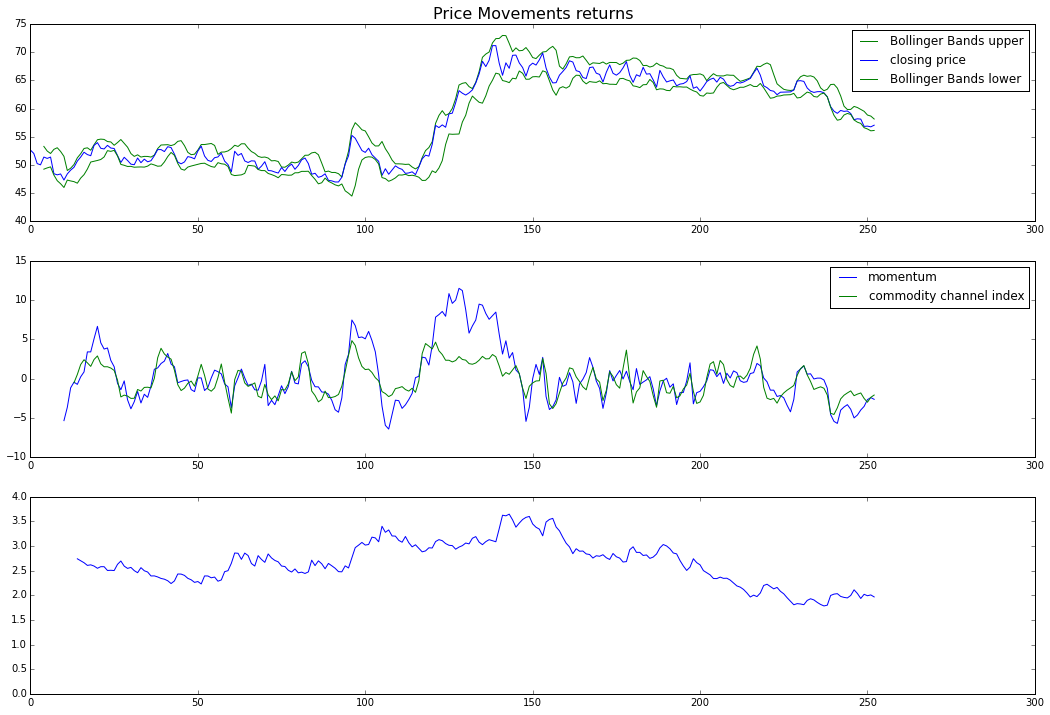

In [278]:
#daily_2009=df_daily['01/01/2009'::]['log_returns_close']

fig=plt.figure(figsize=(18,12))
ax1=fig.add_subplot(311)
ax1.set_title('Price Movements returns',fontsize=16)
ax1=plt.plot(BBANDS_upper,color='green',label='Bollinger Bands upper')
ax1=plt.plot(close,label='closing price')
ax1=plt.plot(BBANDS_lower,color='green',label='Bollinger Bands lower')
ax1=plt.legend()

ax2=fig.add_subplot(312)
ax2=plt.plot(MOM,label='momentum')#pd.rolling_mean(df_daily[start:end]['price']['close'],30).plot()
ax2=plt.plot(CCI/50,label='commodity channel index')
ax2=plt.legend()
ax3=fig.add_subplot(313)
ax3=plt.plot(NATR,label='Normalized Average True Range')
ax3=plt.plot(CDL2CROWS,label='Two Cows')
#ax3=plt.plot(trange,label='True Range')

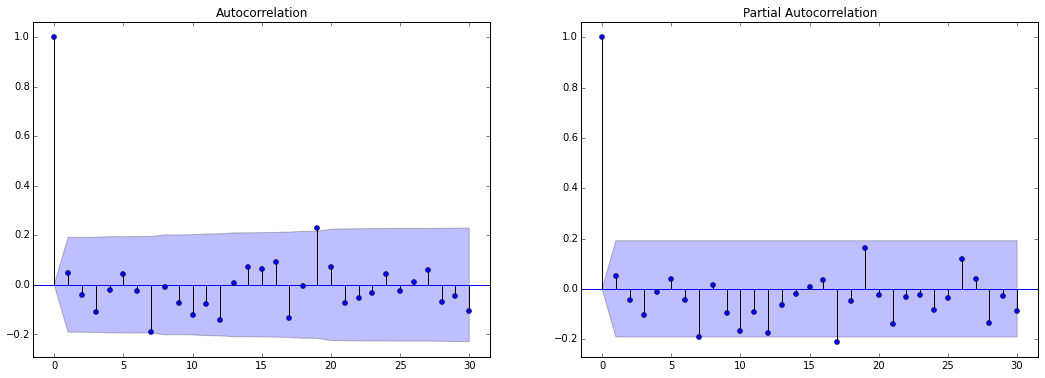

In [213]:
fig=plt.figure(figsize=(18,6))
ax1=fig.add_subplot(121)
ax1=sm.graphics.tsa.plot_acf(df_daily[start:end]['log_returns_close'],lags=30,ax=ax1)
ax2=fig.add_subplot(122)
ax2=sm.graphics.tsa.plot_pacf(df_daily[start:end]['log_returns_close'],lags=30,ax=ax2)

Did not find obvious patterns from the analysis above

### Try model building

In [292]:
#Entire Sample
new_start=(datetime.strptime(start, '%m/%d/%Y')+timedelta(days=60)).strftime('%m/%d/%Y')
y_1=result[new_start:end]['log_returns_close_1'].as_matrix()
X_1=result[new_start:end].drop(['log_returns_close_1','open','high','low'],axis=1).as_matrix()
result[new_start:end].drop(['log_returns_close_1','open','high','low'],axis=1).isnull().values.any()

False

In [293]:
aa=result[new_start:end].drop(['log_returns_close','open','high','low'],axis=1)
pd.isnull(aa).any()

close                    False
log_returns_close_1       True
lr_l1                    False
lr_l2                    False
lr_l3                    False
lr_l4                    False
lr_l5                    False
BBANDS_lower             False
BBANDS_middle            False
BBANDS_upper             False
DEMA                     False
ADX                      False
APO                      False
CCI                      False
MOM                      False
CDL2CROWS                False
NATR                     False
HT_DCPERIOD              False
HT_DCPHASE_inphase       False
HT_DCPHASE_quadrature    False
HT_TRENDMODE             False
dtype: bool

In [294]:
new_start

'03/01/2012'

In [335]:
#Testing sets
X_1_test=X_1[91:120,:] #keep the last 30 days as testing
y_1_test=y_1[91:120]

#Training sets
X_1_training=X_1[:90,:] #keep the last 30 days as testing
y_1_training=y_1[:90]
y_1_test

array([ 0.00847463,  0.01910506,  0.02453394,  0.0334783 , -0.0137662 ,
        0.01655249,  0.03714245,  0.        , -0.04468333, -0.03219193,
        0.03303262, -0.01438874,  0.03380682,  0.0005493 , -0.02024754,
       -0.01212136, -0.02294995,  0.02691259,  0.00759818, -0.00505903,
        0.01371226,  0.0173582 , -0.03870732, -0.02443001, -0.01583611,
        0.00059102,  0.02046855,  0.00984524,  0.01058506])

In [296]:
columns=['Model','R^2','Residual sum of squares','Best Parameters','Data_Range']
model_comparison=pd.DataFrame(columns=columns)

In [343]:
def plot_results(y_tr,y_tr_pred,y_te,y_te_pred,model):
    fig=plt.figure(figsize=(16,4))
    ax1=fig.add_subplot(121)
    ax1.set_title('within sample')
    ax1=plt.plot(y_tr,label='real y',color='blue')
    ax1=plt.plot(y_tr_pred,label='predicted y',color='red')
    ax1=plt.legend(loc=3)
    
    ax2=fig.add_subplot(122)
    ax2.set_title('out of sample')
    ax2=plt.plot(y_te,label='real y',color='blue')
    ax2=plt.plot(y_te_pred,label='predicted y',color='red')
    ax2=plt.legend(loc=3)
    fig.suptitle(model,y=1.05,fontsize=20)

In [344]:
def linear_version(X_tr,y_tr,X_te,y_te):
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_tr, y_tr)
    rss=np.mean((regr.predict(X_te) - y_te) ** 2)
    plot_results(y_tr,regr.predict(X_tr),y_te,regr.predict(X_te),'Linear Model')
    print("Residual sum of squares: %.2f" % rss)
    print('R^2: %.2f' % regr.score(X_te,  y_te))
    return (regr.score(X_te,  y_te),rss,regr.coef_)

Residual sum of squares: 0.03
R^2: -57.11


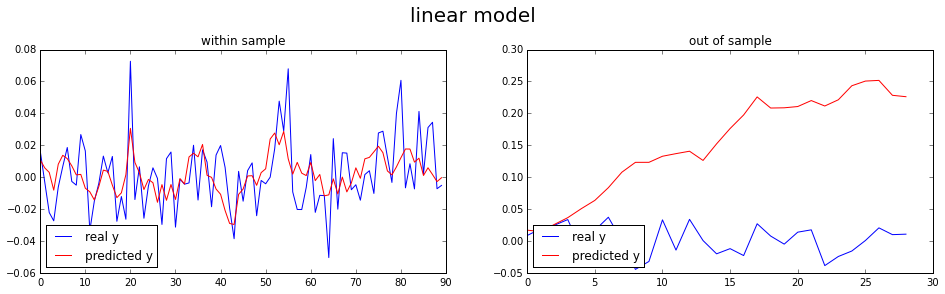

In [345]:
#first half
R_2,Rss,Param=linear_version(X_1_training,y_1_training,X_1_test,y_1_test)
model_comparison = model_comparison.append({'Model':'linear', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

In [286]:
model_comparison

,Model,R^2,Residual sum of squares,Best Parameters,Data_Range
0,linear,-5.592195,0.003862,"[0.00381733352539, -0.00955279584289, -0.00304...",1


In [253]:
class TimeSeriesCV():
    def __init__(self,n,fold):
        self.n=n
        self.fold=fold
    def __iter__(self):
        if self.n<(self.fold+1):
            print("too many folds")
        m=self.n%(self.fold+1)
        chunk=np.arange(self.n)#entire series
        size=(self.n-m)/(self.fold+1)#size of each fold, size of the first fold is size+m
        for i in np.arange(self.fold):
            train_index = chunk[0:(size*(i+1)+m)]
            test_index = chunk[(size*(i+1)+m):(size*(i+2)+m)]
            yield train_index, test_index
    def __len__(self):
        return self.fold 

In [346]:
def kernel_ridge_version(X_tr,y_tr,X_te,y_te,f):
    # Create linear regression object

    tuned_parameters = [{'kernel':['linear'],'alpha': [0.001,0.05,0.01,0.1,1]},
                         {'kernel':['rbf'],'alpha':[0.001,0.05,0.01,0.1,1],'gamma':[0.1,1,10,100,500]}]
    print("# Tuning hyper-parameters")
    clf = grid_search.GridSearchCV(kernel_ridge.KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None), tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=f))
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    plot_results(y_tr,clf.predict(X_tr),y_te,clf.predict(X_te),'Kernel Ridge Linear Regression')
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)

# Tuning hyper-parameters
Best parameters set found on development set:
{'alpha': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
Grid scores on development set:
-3.210 (+/-1.484) for {'alpha': 0.001, 'kernel': 'linear'}
-2.027 (+/-2.741) for {'alpha': 0.05, 'kernel': 'linear'}
-2.506 (+/-2.121) for {'alpha': 0.01, 'kernel': 'linear'}
-1.959 (+/-2.401) for {'alpha': 0.1, 'kernel': 'linear'}
-2.885 (+/-3.401) for {'alpha': 1, 'kernel': 'linear'}
-0.100 (+/-0.261) for {'alpha': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
-0.105 (+/-0.257) for {'alpha': 0.001, 'gamma': 1, 'kernel': 'rbf'}
-0.105 (+/-0.257) for {'alpha': 0.001, 'gamma': 10, 'kernel': 'rbf'}
-0.105 (+/-0.257) for {'alpha': 0.001, 'gamma': 100, 'kernel': 'rbf'}
-0.105 (+/-0.257) for {'alpha': 0.001, 'gamma': 500, 'kernel': 'rbf'}
-0.100 (+/-0.260) for {'alpha': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}
-0.105 (+/-0.257) for {'alpha': 0.05, 'gamma': 1, 'kernel': 'rbf'}
-0.105 (+/-0.257) for {'alpha': 0.05, 'gamma': 10, 'kernel': 'rbf'}
-0.105 (+/

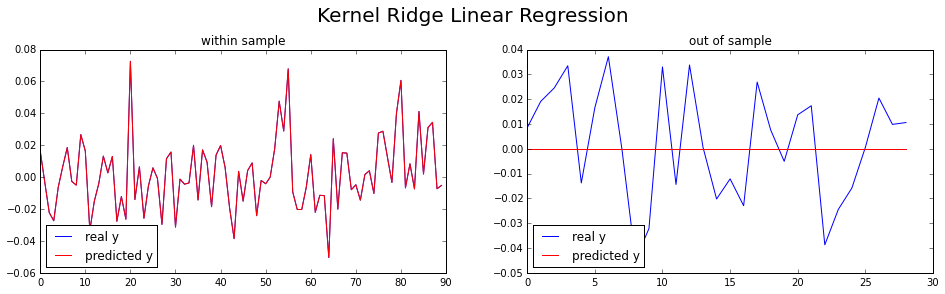

In [347]:
#first half
R_2,Rss,Param=kernel_ridge_version(X_1_training,y_1_training,X_1_test,y_1_test,3)
model_comparison = model_comparison.append({'Model':'Kernel Ridge', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

In [348]:
def svm_version(X_tr,y_tr,X_te,y_te,f):
    # Create linear SVR object
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10,20,30, 50,60,70,80,90,100,1000]}]
    print("# Tuning hyper-parameters")

    clf = grid_search.GridSearchCV(svm.SVR(C=1), tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=f),n_jobs=-1)
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    plot_results(y_tr,clf.predict(X_tr),y_te,clf.predict(X_te),'SVM')
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")

    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)

# Tuning hyper-parameters
Best parameters set found on development set:
{'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
Grid scores on development set:
-0.710 (+/-1.499) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
-0.710 (+/-1.499) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
-0.710 (+/-1.499) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
-0.710 (+/-1.499) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
-0.710 (+/-1.499) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
-0.710 (+/-1.499) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
-0.710 (+/-1.499) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
-0.710 (+/-1.499) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
-0.710 (+/-1.499) for {'kernel': 'linear', 'C': 1}
-0.710 (+/-1.499) for {'kernel': 'linear', 'C': 10}
-0.710 (+/-1.499) for {'kernel': 'linear', 'C': 20}
-0.710 (+/-1.499) for {'kernel': 'linear', 'C': 30}
-0.710 (+/-1.499) for {'kernel': 'linear', 'C': 50}
-0.710 (+/-1.499) for {'kernel': 'linear', 'C': 60}
-0.710 (+/-1.49

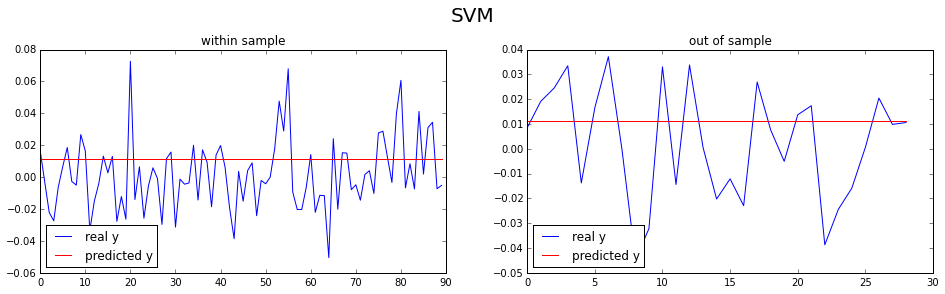

In [349]:
R_2,Rss,Param=svm_version(X_1_training,y_1_training,X_1_test,y_1_test,3)
model_comparison = model_comparison.append({'Model':'SVM', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)

In [330]:
def gbm_version(X_tr,y_tr,X_te,y_te,f):
    # Create GBM object
    tuned_parameters = [{'loss':['huber'],
                         'alpha':[0.1,0.5,0.9],
                         'n_estimators': [100,500,1000], 
                         'learning_rate': [0.01,0.05,0.1],
                         'max_depth': [1, 10, 50,100]}]
    print("# Tuning hyper-parameters")
    clf = grid_search.GridSearchCV(ensemble.GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
          max_depth=1, random_state=0, loss='ls'),tuned_parameters, cv=TimeSeriesCV(len(y_tr),fold=f),n_jobs=-1)
    clf.fit(X_tr, y_tr)
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    plot_results(y_tr,clf.predict(X_tr),y_te,clf.predict(X_te),'GBM')
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('R^2: %.2f' % clf.score(X_te,  y_te))
    rss=np.mean((clf.predict(X_te) - y_te) ** 2)
    print("Residual sum of squares: %.2f" % rss)
    return (clf.score(X_te,  y_te),rss,clf.best_params_)

# Tuning hyper-parameters
Best parameters set found on development set:
{'n_estimators': 1000, 'alpha': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'loss': 'huber'}
Grid scores on development set:
-0.222 (+/-0.494) for {'n_estimators': 100, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'loss': 'huber'}
-0.222 (+/-0.580) for {'n_estimators': 500, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'loss': 'huber'}
-0.222 (+/-0.579) for {'n_estimators': 1000, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'loss': 'huber'}
-0.163 (+/-0.457) for {'n_estimators': 100, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'loss': 'huber'}
-0.161 (+/-0.456) for {'n_estimators': 500, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'loss': 'huber'}
-0.160 (+/-0.458) for {'n_estimators': 1000, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'loss': 'huber'}
-0.163 (+/-0.457) for {'n_estimators': 100, 'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 50, 'loss': 'huber'

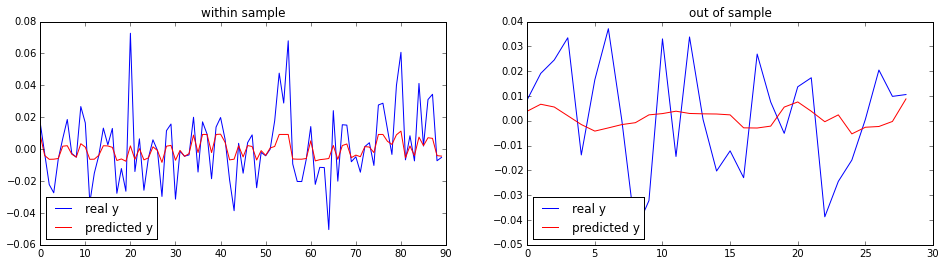

In [339]:
R_2,Rss,Param=gbm_version(X_1_training,y_1_training,X_1_test,y_1_test,3)
model_comparison = model_comparison.append({'Model':'GBM', 'R^2': R_2,'Residual sum of squares':Rss,
                                            'Best Parameters': Param,'Data_Range':1},ignore_index=True)